In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import cv2

import tensorflow as tf
print(tf.__version__)

from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau

2.13.0


In [2]:
train = pd.read_csv('Letters/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('Letters/sign_mnist_test/sign_mnist_test.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
train.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [4]:
train_labels = train['label']
train_pixels = train.drop(columns = ['label'])

test_labels = test['label']
test_pixels = test.drop(columns = ['label'])
print(train_labels.shape, train_pixels.shape)
print(test_labels.shape, test_pixels.shape)

(27455,) (27455, 784)
(7172,) (7172, 784)


In [5]:
train_pixels = np.array(train_pixels)
train_pixels = train_pixels.reshape((-1, 28, 28, 1))
X_train = train_pixels/255.

test_pixels = np.array(test_pixels)
test_pixels = test_pixels.reshape((-1, 28, 28, 1))
X_test = test_pixels/ 255.

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(train_labels)
y_test = label_binarizer.fit_transform(test_labels)

train_pixels.shape

(27455, 28, 28, 1)

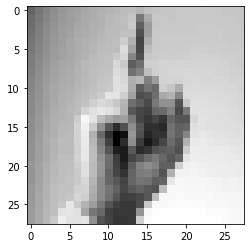

In [6]:
plt.imshow(X_train[0], cmap = 'gray')

In [7]:
DataGenerator = ImageDataGenerator(rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1)

DataGenerator.fit(X_train)

LrReduce =  ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [8]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

2024-04-24 15:53:56.430933: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-24 15:53:56.430963: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-24 15:53:56.430977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-24 15:53:56.431039: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-24 15:53:56.431375: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

In [9]:
history = model.fit(DataGenerator.flow(X_train,y_train, batch_size = 128),
                    epochs = 20 , validation_data = (X_test, y_test), 
                    callbacks = [LrReduce])


Epoch 1/20


2024-04-24 15:53:57.603291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-24 15:53:57.714554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


214/215 [============================>.] - ETA: 0s - loss: 1.4115 - accuracy: 0.5833

2024-04-24 15:54:06.591568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 12s 48ms/step - loss: 1.4079 - accuracy: 0.5841 - val_loss: 3.8106 - val_accuracy: 0.1372 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 10s 45ms/step - loss: 0.4187 - accuracy: 0.8639 - val_loss: 1.0473 - val_accuracy: 0.6489 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 10s 47ms/step - loss: 0.2593 - accuracy: 0.9175 - val_loss: 0.4080 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 10s 44ms/step - loss: 0.2103 - accuracy: 0.9345 - val_loss: 0.4338 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 10s 47ms/step - loss: 0.1632 - accuracy: 0.9513 - val_loss: 0.2903 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 10s 44ms/step - loss: 0.1631 - accuracy: 0.9542 - val_loss: 0.1531 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 10s 44ms/step -

In [10]:
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 9ms/step - loss: 0.0156 - accuracy: 0.9957
Accuracy of the model is -  99.5677649974823 %


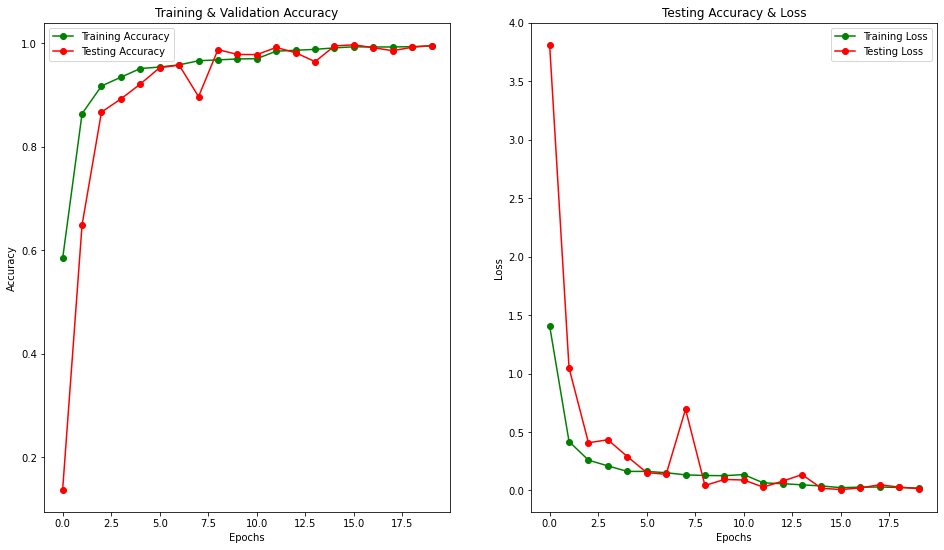

In [11]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_batches(directory, shuffle=False):
    return ImageDataGenerator().flow_from_directory(
        directory=directory,
        target_size=(28, 28),
        batch_size=16,
        shuffle=shuffle
    )

paths = {'train': 'Digits/train', 
         'val': 'Digits/valid', 
         'test': 'Digits/test'}

train_batches = create_batches(paths['train'])
validation_batches = create_batches(paths['val'])
test_batches = create_batches(paths['test'], shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [17]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 10 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

history = model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    epochs=20,
    verbose=1,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_6 (Bat  (None, 28, 28, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 50)       

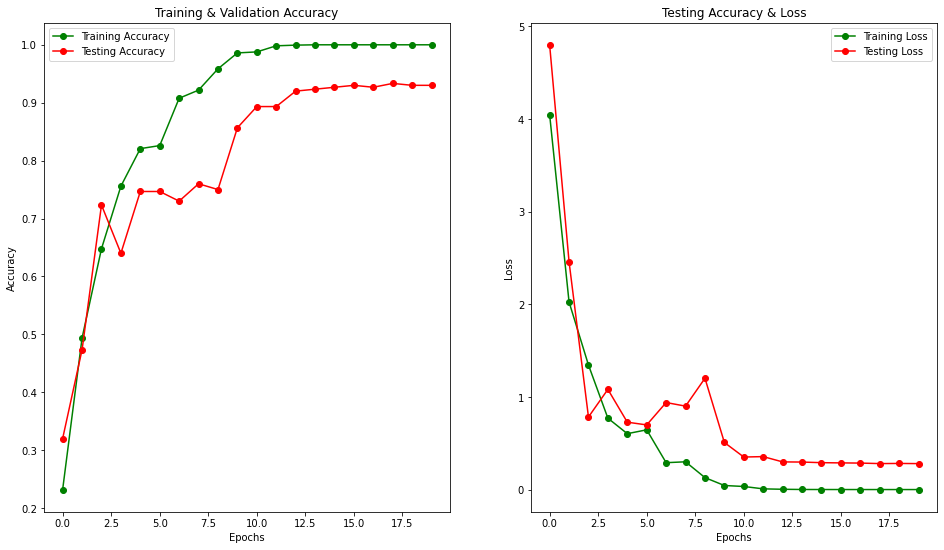

In [15]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [58]:
digits_pixels = []
digits_labels = []

paths = {'train': 'Digits/train', 
         'val': 'Digits/valid', 
         'test': 'Digits/test'}

for dataset in paths.values():
    for class_ in os.listdir(dataset):
        if class_ == '.DS_Store':
            continue
        else:
            for image in os.listdir(os.path.join(dataset, class_)):
                img = cv2.imread(os.path.join(dataset, class_, image))
                
                digits_pixels.append(img)
                digits_labels.append(class_)
                
print(type(digits_pixels))
arr = np.asarray()
arr.shape
                

<class 'list'>


AttributeError: 'list' object has no attribute 'flatten'